#### Setup ####

This project requires Python 3.7 or above:

In [2]:
import sys

assert sys.version_info >= (3,7)


It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse('1.0.1')

#### Look at the Big Picture

The task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California.

The model should learn from this data and be able to predict the median
housing price in any district, given all the other metrics.

Determine what kind of training supervision the model will need:

This is a **supervised learning** task, since the model can be trained with **labeled** examples (each instance comes with the expected output, i.e., the district’s median housing price). It is a **regression** task since the model will be asked to **predict** a value.

This is a **multiple regression problem**, since the system will use **multiple features** to make a prediction (the district’s population, the median income, etc.).

It is also a **univariate regression problem**, since we are only trying to predict a single value for each district. If we were trying to predict multiple values per district, it would be a** multivariate regression problem**.

There is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.

**Select a Performance Measure**

Next step is to select a performance measure. A typical performance measure for regression problems is the **root mean square error (RMSE)**. It gives an idea of how much error the system typically makes in its predictions, with a higher weight given to large errors.

**RMSE (Root Mean Square Error)** is a common performance metric for regression tasks. It calculates the square root of the average squared differences between predicted and actual values, which means it gives more weight to large errors. For example, if a model predicts a house price as $158,400 while the actual price is $156,400, the error is $2,000. RMSE would square this error (4,000,000), take the average across all data points, and then take the square root to get the final score.

**MAE (Mean Absolute Error)**, on the other hand, measures the average of the absolute differences between predictions and true values. It treats all errors equally, regardless of their size. Using the same example, the MAE would simply consider the $2,000 difference without squaring. While RMSE is more sensitive to outliers, MAE is more robust when data contains extreme values. Choosing between them depends on whether you want to penalize large errors more strongly (RMSE) or treat all errors equally (MAE).

**Check the Assumptions**

It is good practice to list and verify the assumptions that have been made so far (by you or others); this can help you catch serious issues early on. For example, the district prices that your system outputs are going to be fed into a downstream machine learning system, and you assume that these prices are going to be used as such. But what if the downstream system converts the prices into categories (e.g., “cheap”, “medium”, or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months.

#### Get the Data

**Download the Data**

In [6]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path('datasets/housing.tgz')
  if not tarball_path.is_file():
    Path('datasets').mkdir(parents=True, exist_ok=True)
    url = 'https://github.com/ageron/data/raw/main/housing.tgz'
    urllib.request.urlretrieve(url, tarball_path)

  with tarfile.open(tarball_path) as housing_tarball:
    housing_tarball.extractall(path='datasets')
  return pd.read_csv(Path('datasets/housing/housing.csv'))

housing = load_housing_data()

#### Take a Quick Look at the Data Structure

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes:

longitude, latitude housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, and ocean_proximity.

The info() method is useful to get a quick description of the data, in particular the total number of rows, each attribute’s type, and the number of non-null values.

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- The total_bedrooms attribute has only 20,433 non-null values, meaning that
207 districts are missing this feature.
- All attributes are numerical, except for ocean_proximity. It is probably a categorical attribute.

In [11]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


The describe() method shows a summary of the numerical attributes.

In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to
plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis).

In [13]:
# extra code – code to save the figures as high-res PNGs for the book
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

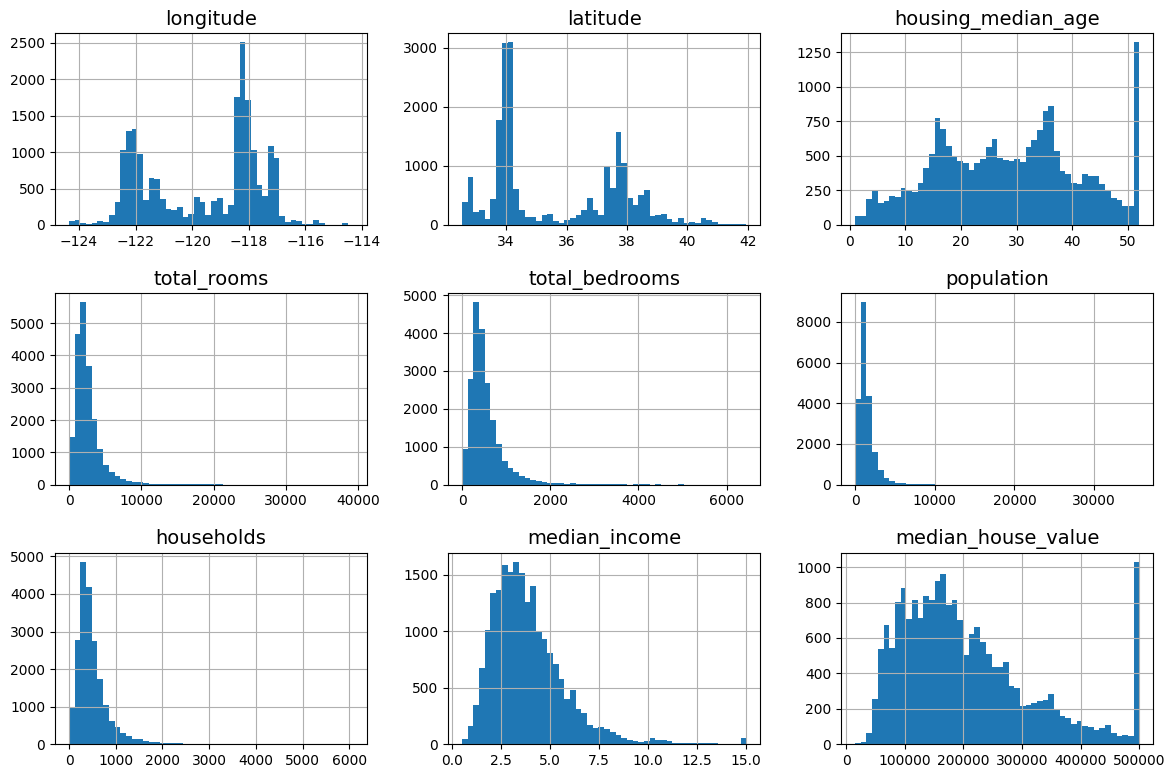

In [14]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

- The median_income attribute is scaled and capped
- The housing_median_age and median_house_value attributes are also capped.
- The features have very different scales.
- Many histograms are right-skewed.

#### Create a Test Set

Creating a test set is theoretically simple; pick some instances randomly,
typically 20% of the dataset (or less if your dataset is very large), and set
them aside:

In [23]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [24]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [25]:
len(test_set)

4128

This works, but it is not perfect: if you run the program again, it will
generate a different test set.

One solution is to save the test set on the first run and then load it in
subsequent runs. Another option is to set the random number generator’s seed
(e.g., with np.random.seed(42)) before calling np.random.permutation() so
that it always generates the same shuffled indices.

To ensure a consistent train/test split even after updating the dataset, you can assign instances to the test set based on a hash of their unique and immutable identifiers, keeping roughly the same distribution while avoiding data leakage.

In [26]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

The housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [27]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'index')


If you use the row index as a unique identifier, you need to make sure that
new data gets appended to the end of the dataset and that no row ever gets
deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [29]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'id')


Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split(), which does pretty
much the same thing as the shuffle_and_split_data() function we defined earlier, with a couple of additional features. First, there is a random_state
parameter that allows you to set the random generator seed. Second, you can
pass it multiple datasets with an identical number of rows, and it will split
them on the same indices (this is very useful, for example, if you have a
separate DataFrame for labels):

In [32]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [33]:
test_set["total_bedrooms"].isnull().sum()

np.int64(44)

Suppose that the **median income** is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute.

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

In [34]:
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

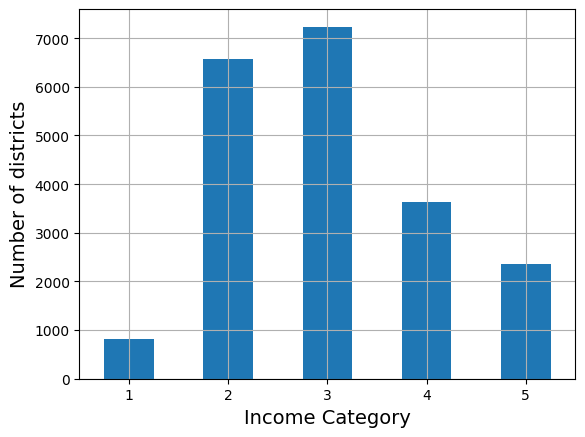

In [36]:
housing['income_cat'].value_counts().sort_index().plot.bar(
    rot=0,
    grid=True
)
plt.xlabel('Income Category')
plt.ylabel('Number of districts')
plt.show()